In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [8]:
# Define constants and model base parameters
E_total = 4e-5 #enzyme
S1_0 = 4e-5 #specific substrate
S2_0 = 1e-3 #nonspecific substrate
P1_0 = 0.0 #labelled S1
P2_0 = 0.0 #labelled S2
ES1_0 = 0.0
ES2_0 = 0.0

Km1_base = 1e-6
Km2_base = 8e-3
kcat1 = 0.11
kcat2 = 0.0011
kon1_base = 1e7
kon2_base = 1e7
koff1 = Km1_base * kon1_base - kcat1
koff2 = Km2_base * kon2_base - kcat2

# Define evaluation parameters
Kconf_range = np.logspace(-3, 1, 30)
E_total_range = np.logspace(0, 4, 30) * 1e-6
t_target = 300  # seconds

# Initialize matrix to hold log2(V1/V2)
V_ratios_single = np.zeros((len(E_total_range), len(Kconf_range)))

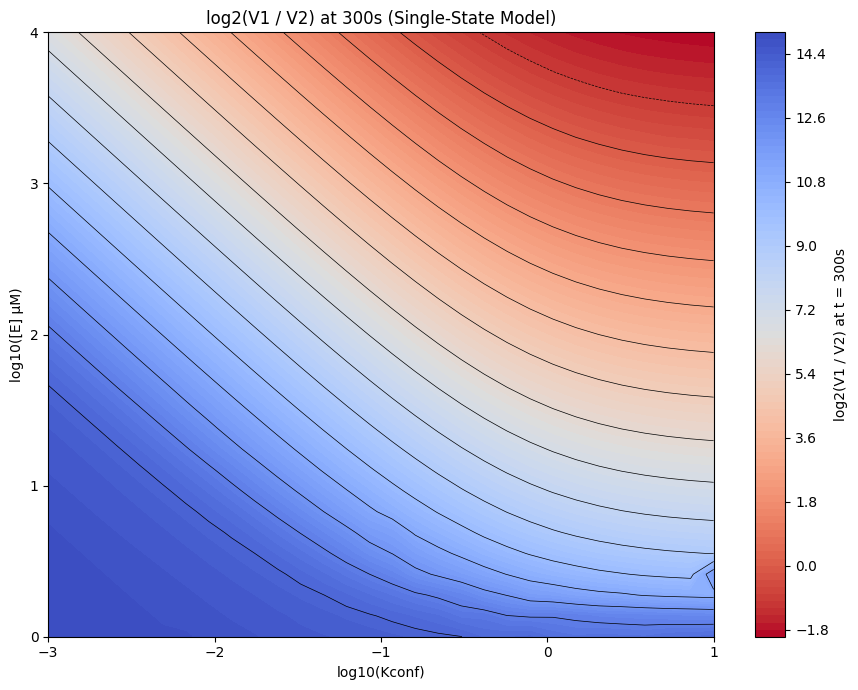

In [9]:
# Define ODE system for single-state model
def ode_system_single(t, y, E_total, kon1, kon2):
    S1, S2, P1, P2, ES1, ES2 = y
    E_free = E_total - ES1 - ES2
    dS1_dt = -kon1 * E_free * S1 + koff1 * ES1
    dS2_dt = -kon2 * E_free * S2 + koff2 * ES2
    dP1_dt = kcat1 * ES1
    dP2_dt = kcat2 * ES2
    dES1_dt = kon1 * E_free * S1 - (koff1 + kcat1) * ES1
    dES2_dt = kon2 * E_free * S2 - (koff2 + kcat2) * ES2
    return [dS1_dt, dS2_dt, dP1_dt, dP2_dt, dES1_dt, dES2_dt]

# solve across enzyme concentration and Kconf values
for i, E_val in enumerate(E_total_range):
    for j, Kconf_val in enumerate(Kconf_range):
        Km1_mod = Km1_base * (1 + 1 / Kconf_val)
        Km2_mod = Km2_base * (1 + 1 / Kconf_val)
        kon1_mod = (koff1 + kcat1) / Km1_mod
        kon2_mod = (koff2 + kcat2) / Km2_mod
        y0 = [S1_0, S2_0, P1_0, P2_0, ES1_0, ES2_0]
        sol = solve_ivp(
            ode_system_single,
            [0, t_target],
            y0,
            args=(E_val, kon1_mod, kon2_mod),
            t_eval=[t_target],
            method="LSODA",
        )
        V1 = sol.y[2, -1] / t_target
        V2 = sol.y[3, -1] / t_target
        V_ratios_single[i, j] = np.log2(V1 / V2) if V2 > 0 else np.nan

# Plot results
Kconf_log = np.log10(Kconf_range)
E_total_log = np.log10(E_total_range * 1e6)
X, Y = np.meshgrid(Kconf_log, E_total_log)

fig, ax = plt.subplots(figsize=(9, 7))
contourf = ax.contourf(X, Y, V_ratios_single, levels=100, cmap="coolwarm_r")
contour_lines = ax.contour(
    X, Y, V_ratios_single, levels=np.arange(-5, 15, 1), colors="black", linewidths=0.5
)
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label(f"log2(V1 / V2) at t = {t_target}s")

ax.set_xlabel("log10(Kconf)")
ax.set_ylabel("log10([E] µM)")
ax.set_title(f"log2(V1 / V2) at {t_target}s (Single-State Model)")
ax.set_xticks(np.arange(np.floor(X.min()), np.ceil(X.max()) + 1).astype(int))
ax.set_yticks(np.arange(np.floor(Y.min()), np.ceil(Y.max()) + 1).astype(int))

plt.tight_layout()
plt.show()
